In [19]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, binom_test , chi2_contingency, norm
from statsmodels.stats.weightstats import _tconfint_generic

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('credit_card_default_analysis.csv')

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Вопрос 1.** Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [5]:
df_limit_0 = df['LIMIT_BAL'][df.default==0]
df_limit_1 = df['LIMIT_BAL'][df.default==1]
df_limit_0.median(),df_limit_1.median()

(150000.0, 90000.0)

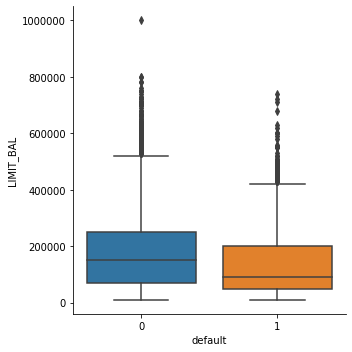

In [6]:
# проверяем нулевую гипотезу о равенстве медиан в двух выборках против двусторонней альтернативы

sns.catplot(y='LIMIT_BAL',x='default',data=df,kind="box");
# медианы попадают в квартили друг друга, поэтому сразу отвергнуть гипотезу о их равенстве мы не можем

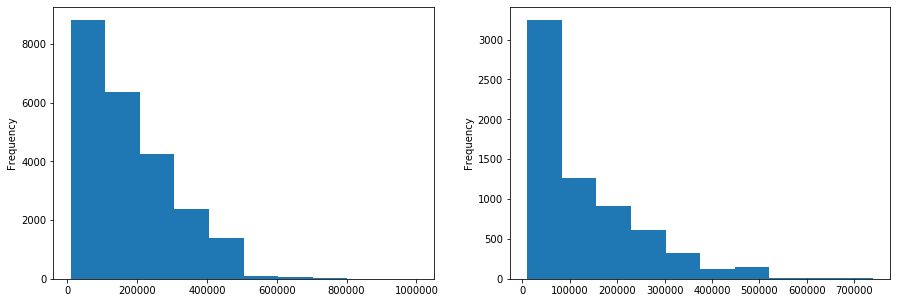

In [7]:
fig, axes = plt.subplots(1,2 ,figsize=(15,5))
df_limit_0.plot(kind='hist',ax=axes[0])
df_limit_1.plot(kind='hist',ax=axes[1]);

# распределение отлично от нормального,  поэтому воспользуемся бутстрепом для сравнения медиан 

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
limit_0_median_scores = list(map(np.median, get_bootstrap_samples(df_limit_0.values, 1000)))
limit_1_median_scores = list(map(np.median, get_bootstrap_samples(df_limit_1.values, 1000)))
print("95% доверительный интервал для медианы кредитного лимита (default=0):", stat_intervals(limit_0_median_scores, 0.05))
print("95% доверительный интервал для медианы кредитного лимита (default=1):", stat_intervals(limit_1_median_scores, 0.05))

# интервалы не пересекаются

95% доверительный интервал для медианы кредитного лимита (default=0): [150000. 150000.]
95% доверительный интервал для медианы кредитного лимита (default=1): [80000. 90000.]


In [10]:
# для определения практической значимости воспользуемся критерием fold_change
def fold_change(control, treatment ):
    if control > treatment:
        return -(control/treatment)
    else: return treatment/control
    
print('fold_change =',abs(fold_change(df_limit_0.median(),df_limit_1.median())))

fold_change = 1.6666666666666667


**Вывод (a)**: доверительные интервалы, полученные методом бутстрепа, не пересекаются, поэтому гипотезу о их равенстве можно отвергнуть. Критерий fold_change превышает порог 1.5, поэтому разница медиан существенна и с практической точки зрения.

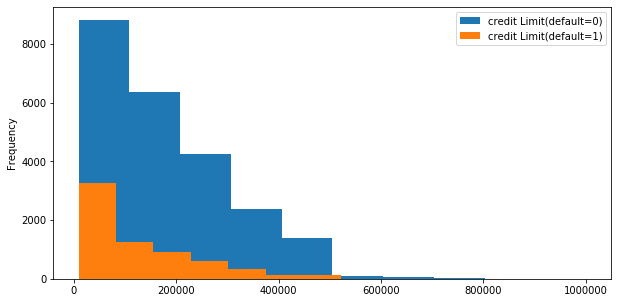

In [11]:
# Проверим гипотезу о равенстве распеределений в двух выборках с помощью перестановочного критерия
# против двусторонней альтернативы

fig= plt.subplots(figsize=(10,5))
df_limit_0.plot(kind='hist', legend=True,label='credit Limit(default=0)')
df_limit_1.plot(kind='hist', legend=True,label='credit Limit(default=1)');

In [12]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [13]:
permutation_test(df_limit_0,df_limit_1,10000)

# перестановочный критерий отвергает Н0 о равенстве средних 

0.0001

In [14]:
mannwhitneyu(df_limit_0,df_limit_1)

# и Манн-уитни тоже, но на нем мы не будем делать акцента, тк в данных есть повторяющиеся значения 
# и его применение спорно

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

In [15]:
# для определения практической значимости воспользуемся критерием fold_change

print('fold_change =',abs(fold_change(df_limit_0.mean(),df_limit_1.mean())))

fold_change = 1.3688432586435533


**Вывод (b)**: перестановочный критерий отвергает Н0 (на уровне значимости 0.05 ) о равенстве средних, а следовательно и о равенстве распределений. Критерий fold_change не достигает отметки в 1.5, поэтому мы не можем с уверенностью говорить о практической значимости результатов.

**Вопрос 2.** Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [16]:
#проверяем гипотезу о том, что гендерный состав не различается против двусторонней альтернативы(кого-то больше/меньше)

#  соотношение мужчин и женщин вернувших и не вернувших кредит 
SEX_def = df.groupby(['SEX','default'])['SEX'].aggregate('count').unstack().T
SEX_def

SEX,1,2
default,,
0,9015,14349
1,2873,3763


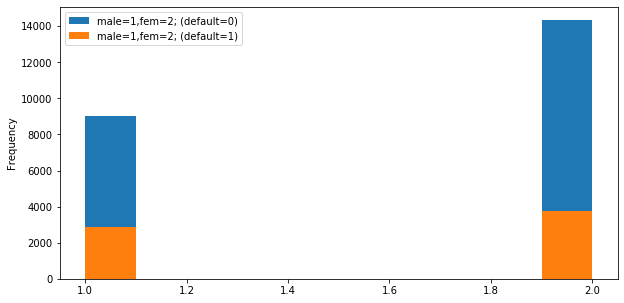

In [17]:
# визуализируем соотношение мучин и женщин
fig= plt.subplots(figsize=(10,5))
df['SEX'][df.default==0].plot(kind='hist', legend=True, label = 'male=1,fem=2; (default=0)')
df['SEX'][df.default==1].plot(kind='hist', legend=True, label = 'male=1,fem=2; (default=1)');

In [18]:
# воспользуемся корреляцией Метьюса (тк имеем бинарные признаки) между полом и возвратом кредита

def MCC(a,b,c,d):
    return (a*d-b*c)/((a+b)*(a+c)*(b+d)*(c+d))**0.5

MCC(SEX_def[1][0],SEX_def[1][1],SEX_def[2][0],SEX_def[2][1])

-0.03996057770544159

In [19]:
# проверим гипотезу о том, что коэффициент корреляции Мэтьюса значимо не отличается от нуля 

_,p,_,_ = chi2_contingency(SEX_def)

print('гипотеза о том, что гендерный состав людей НЕ различается - отвергается \np-value:',p)

гипотеза о том, что гендерный состав людей НЕ различается - отвергается 
p-value: 4.944678999412044e-12


In [30]:
# Еще один способ решения через биноминальные криерии
# Воспользуемся биноминальным критерием, тк наши данные принимают всего 2 значения(мужчина/женщина)

print('гипотеза о том, что гендерный состав людей НЕ вернувших кредит одинаков - отвергается \np-value:',
      binom_test(9015,23364, 0.5, alternative = 'two-sided'))
print('гипотеза о том, что гендерный состав людей вернувших кредит одинаков - отвергается \np-value:',
      binom_test(2873,6636, 0.5, alternative = 'two-sided') )

# тк отвергаются обе гипотезы, гендерный состав различен


гипотеза о том, что гендерный состав людей НЕ вернувших кредит одинаков - отвергается 
p-value: 4.8083897998530436e-269
гипотеза о том, что гендерный состав людей вернувших кредит одинаков - отвергается 
p-value: 8.3397366690338e-28


In [20]:
# решение через  Z-критерий для разности долей в независимых выборках

def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - norm.cdf(z_stat)

In [29]:
print ("95%% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками)\n\
между мужчинами и женщинами: [%f, %f]" %proportions_diff_confint_ind(df[df.SEX == 1].default.values,
                                                    df[df.SEX == 2].default.values))
print ("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(df[df.SEX == 1].default.values,
                                                    df[df.SEX == 2].default.values)))


95% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками)
между мужчинами и женщинами: [0.024207, 0.043612]
p-value:  4.472866521609831e-12


**Вывод**: Мы имеем статистически значимую корреляцию между полом и возвратом кредита, поэтому гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит не различается - отвергается

**Вопрос 3.** Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [62]:
# построим таблицу сопряженности
contingency = df.groupby(['EDUCATION','default'])['EDUCATION'].aggregate('count').unstack().T
contingency.fillna(0, inplace=True)

In [65]:
contingency

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14.0,8549.0,10700.0,3680.0,116.0,262.0,43.0
1,0.0,2036.0,3330.0,1237.0,7.0,18.0,8.0


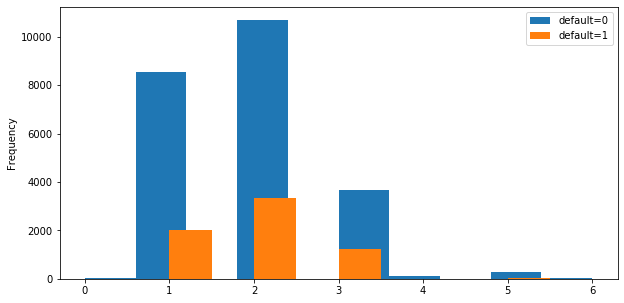

In [64]:
fig= plt.subplots(figsize=(10,5))
df['EDUCATION'][df.default==0].plot(kind='hist', legend=True, label = 'default=0')
df['EDUCATION'][df.default==1].plot(kind='hist', legend=True, label = 'default=1');

In [66]:
# получим ожидаемые значения с помощью критерия кси квадрат, а так же проверим гипотезу о том, 
# что нет связи между образованием и возвратом долга против альтернативы о том, что связь есть
# условия для этого теста выполняются, у нас более 40 элементов, и не более 20% ячеек с значением менее 5)

chi,p,dof,expect = chi2_contingency(contingency)

print('как мы видим, гипотеза об отсутствии связи отвергается\np-value:',p)

как мы видим, гипотеза об отсутствии связи отвергается
p-value: 1.2332626245415605e-32


In [74]:
contingency.iloc[0,:].values

array([   14.,  8549., 10700.,  3680.,   116.,   262.,    43.])

In [76]:
# посмотрим на новую таблицу сопряженности с ожидаемыми значениями
contingency_2 = pd.DataFrame({'наблюдаемые_0':contingency.iloc[0,:].values, 
                              'наблюдаемые_1':contingency.iloc[1,:].values, 
                              'ожидаемые_0':expect[0], 
                              'ожидаемые_1':expect[1]} ,index=[0,1,2,3,4,5,6])
contingency_2

,наблюдаемые_0,наблюдаемые_1,ожидаемые_0,ожидаемые_1
0,14.0,0.0,10.9032,3.0968
1,8549.0,2036.0,8243.5980,2341.4020
2,10700.0,3330.0,10926.5640,3103.4360
3,3680.0,1237.0,3829.3596,1087.6404
4,116.0,7.0,95.7924,27.2076
5,262.0,18.0,218.0640,61.9360
6,43.0,8.0,39.7188,11.2812


In [77]:
# добавим разность
contingency_2['разность_0'] = contingency_2['ожидаемые_0']-contingency_2['наблюдаемые_0']
contingency_2['разность_1'] = contingency_2['ожидаемые_1']-contingency_2['наблюдаемые_1']
contingency_2

,наблюдаемые_0,наблюдаемые_1,ожидаемые_0,ожидаемые_1,разность_0,разность_1
0,14.0,0.0,10.9032,3.0968,-3.0968,3.0968
1,8549.0,2036.0,8243.5980,2341.4020,-305.4020,305.4020
2,10700.0,3330.0,10926.5640,3103.4360,226.5640,-226.5640
3,3680.0,1237.0,3829.3596,1087.6404,149.3596,-149.3596
4,116.0,7.0,95.7924,27.2076,-20.2076,20.2076
5,262.0,18.0,218.0640,61.9360,-43.9360,43.9360
6,43.0,8.0,39.7188,11.2812,-3.2812,3.2812


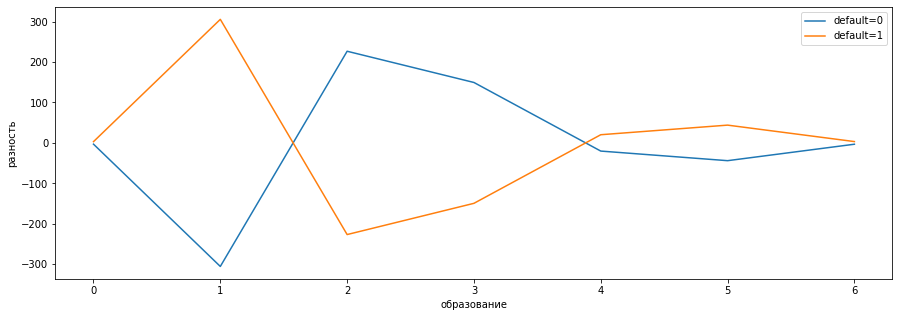

In [78]:
# визуализируем полученые данные для интерпретации

fig = plt.subplots(figsize=(15,5))
plt.plot(contingency_2.index, contingency_2['разность_0'])
plt.plot(contingency_2.index, contingency_2['разность_1'])
plt.xlabel('образование')
plt.ylabel('разность');
plt.legend(['default=0','default=1']);

# 1 = магистр
# 2 = бакалавр

**Вывод**: как мы видим из графика, наибольшее ожидание возврата от людей с образованием магистра, наибольшее ожидание невозврата - у бакалавров

**Вопрос 4.** Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [26]:
# Тк мы имеем категориальные признаки, воспользуемся критерием V-Крамера для того, чтобы найти взаимосвязь между переменными

contingency3 = df.groupby(['MARRIAGE','default'])['MARRIAGE'].aggregate('count').unstack().T
contingency3

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


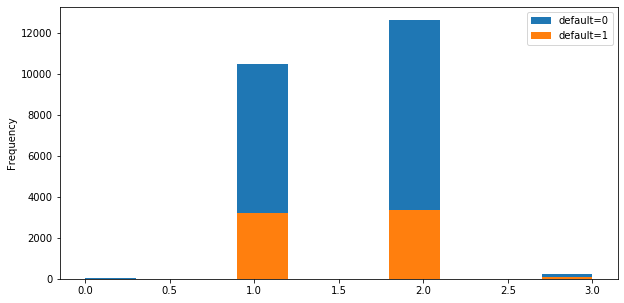

In [33]:
fig= plt.subplots(figsize=(10,5))
df['MARRIAGE'][df.default==0].plot(kind='hist', legend=True, label = 'default=0')
df['MARRIAGE'][df.default==1].plot(kind='hist', legend=True, label = 'default=1');

In [79]:
# Рассчитаем значение хи-квадрат, проверим есть ли связь между семейным положением и дефолтом. Н0-связи нет,Н1-есть
# условия для этого теста выполняются, у нас более 40 элементов, и не более 20% ячеек с значением менее 5)

chi_sq,p,_,_ = chi2_contingency(contingency3)
print('кси-квадрат=',chi_sq,'p-value=',p)

кси-квадрат= 35.66239583433609 p-value= 8.825862457577375e-08


In [50]:
n = contingency3.sum().sum()
k = max(2,4)-1
V_Kramer = ( chi_sq/(n*k) )**0.5
print('V_Kramer=',V_Kramer)

V_Kramer= 0.01990600016587296


**Вывод**: критерий Крамера принимает значения от 0 до 1, где 1 - это полное совпадение переменных. Мы имеем 0.02, что говорит о довольно слабой взаимосвязи. Гипотеза об отсутствие взаимосвязи отвергается

**Вопрос 5.** Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [38]:
df_age_0 = df['AGE'][df.default==0]
df_age_1 = df['AGE'][df.default==1]
df_age_0.median(),df_age_1.median()

(34.0, 34.0)

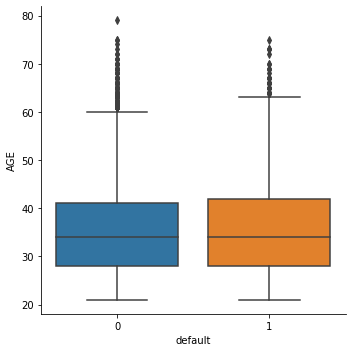

In [39]:
# проверяем нулевую гипотезу о равенстве медиан в двух выборках против двусторонней альтернативы
# медианы идентичны, очень похоже, что гипотеза верна 

sns.catplot(y='AGE',x='default',data=df,kind="box");

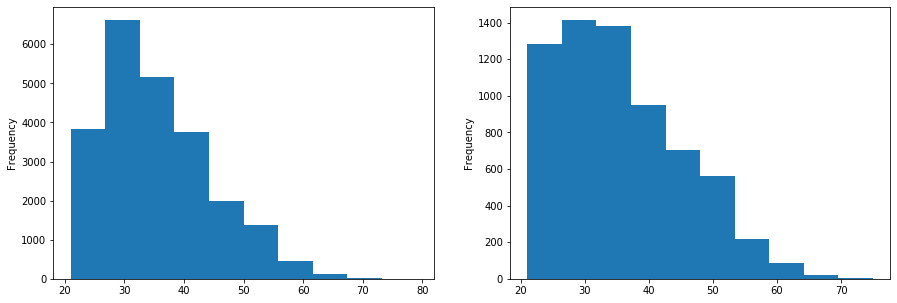

In [40]:
fig, axes = plt.subplots(1,2 ,figsize=(15,5))
df_age_0.plot(kind='hist',ax=axes[0])
df_age_1.plot(kind='hist',ax=axes[1]);

# распределение отлично от нормального,  поэтому воспользуемся бутстрепом для сравнения медиан 

In [41]:
df_age_0_median_scores = list(map(np.median, get_bootstrap_samples(df_age_0.values, 1000)))
df_age_1_median_scores = list(map(np.median, get_bootstrap_samples(df_age_1.values, 1000)))
print("95% доверительный интервал для медиан возвратов (default=0):", stat_intervals(df_age_0_median_scores, 0.05))
print("95% доверительный интервал для медиан возвратов (default=1):", stat_intervals(df_age_1_median_scores, 0.05))

# Интервалы пересекаются

95% доверительный интервал для медиан возвратов (default=0): [34. 34.]
95% доверительный интервал для медиан возвратов (default=1): [34. 35.]


In [86]:
# для определения практической значимости воспользуемся критерием fold_change
print('fold_change =',abs(fold_change(df_age_0.median(),df_age_1.median())))

fold_change = 1.0


**Вывод (a)**: доверительные интервалы, полученные методом бутстрепа, пересекаются, поэтому гипотезу о их равенстве отвергнуть нельзя. Критерий fold_change не превышает порог 1.5, поэтому мы не можем с уверенностью говорить о практической значимости результатов.

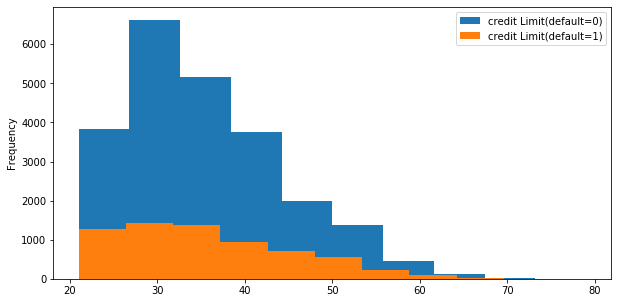

In [43]:
# проверим гипотезу о равенстве распеределений в двух выборках с помощью перестановочного критерия 
# против двусторонней альтернативы

fig= plt.subplots(figsize=(10,5))
df_age_0.plot(kind='hist', legend=True,label='credit Limit(default=0)')
df_age_1.plot(kind='hist', legend=True,label='credit Limit(default=1)');

In [44]:
# перестановочный критерий отвергает Н0 о равенстве средних 
permutation_test(df_age_0,df_age_1,10000)

0.016

In [45]:
# для определения практической значимости воспользуемся критерием fold_change
print('fold_change =',abs(fold_change(df_age_0.mean(),df_age_1.mean())))

fold_change = 1.0087096649003602


**Вывод (b)**: перестановочный критерий отвергает Н0 о равенстве средних, а следовательно и о равенстве распределений. Критерий fold_change не достигает отметки в 1.5, поэтому мы не можем с уверенностью говорить о практической значимости результатов.